# Image Captioning

## Part 4: Generate Captions for Test Images

---

In this notebook, we will use our trained model to generate captions for images in the test dataset.

- [Step 1](#step1): Get Data Loader for Test Dataset 
- [Step 2](#step2): Load Trained Models
- [Step 3](#step3): Finish the Sampler
- [Step 4](#step4): Clean up Captions
- [Step 5](#step5): Generate Predictions

First, we will import the relevant libraries and modules.

In [1]:
%load_ext autoreload
%autoreload 2

import os
from pycocotools.coco import COCO
from torchvision import transforms
import torch
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from data_loader import get_loader
from model import EncoderCNN, DecoderRNN
from utils import clean_sentence, get_prediction

<a id='step1'></a>
## Step 1: Get Data Loader for Test Dataset

The transform steps in `transform_test` will be used to pre-process the test images. They are slightly different from those used to pre-process the training images (in **2_Training.ipynb**). Here we won't use the image augmentation step, i.e. `RandomHorizontalFlip()`, and will use `CenterCrop()` instead of `RandomCrop()`.

In [2]:
# Define a transform to pre-process the testing images
transform_test = transforms.Compose([ 
    transforms.Resize(256),                          # smaller edge of image resized to 256
    transforms.CenterCrop(224),                      # get 224x224 crop from the center
    transforms.ToTensor(),                           # convert the PIL Image to a tensor
    transforms.Normalize((0.485, 0.456, 0.406),      # normalize image for pre-trained model
                         (0.229, 0.224, 0.225))])

# Create the data loader
data_loader = get_loader(transform=transform_test,    
                         mode='test')

Vocabulary successfully loaded from vocab.pkl file!


The code cell below visualizes an example test image, before and after pre-processing is applied.

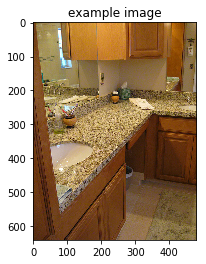

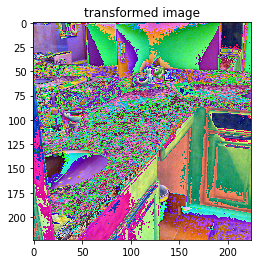

In [3]:
# Obtain sample image before and after pre-processing
orig_image, image = next(iter(data_loader))
# Convert image from torch.FloatTensor to numpy ndarray
transformed_image = image.numpy()
# Remove the first dimension which is batch_size euqal to 1
transformed_image = np.squeeze(transformed_image)
transformed_image = transformed_image.transpose((1, 2, 0))

# Visualize sample image, before pre-processing
plt.imshow(np.squeeze(orig_image))
plt.title('example image')
plt.show()
# Visualize sample image, after pre-processing
plt.imshow(transformed_image)
plt.title('transformed image')
plt.show()

<a id='step2'></a>
## Step 2: Load Trained Models

In the next code cell, we will load the trained encoder and decoder from the previous notebook (**2_Training.ipynb**). 

In [5]:
# Load the most recent checkpoint
checkpoint = torch.load(os.path.join('./models', 'model-7.pkl'))

# Specify values for embed_size and hidden_size - we use the same values as in training step
embed_size = 256
hidden_size = 512

# Get the vocabulary and its size
vocab = data_loader.dataset.vocab
vocab_size = len(vocab)

# Initialize the encoder and decoder, and set each to inference mode
encoder = EncoderCNN(embed_size)
encoder.eval()
decoder = DecoderRNN(embed_size, hidden_size, vocab_size)
decoder.eval()

# Load the pre-trained weights
encoder.load_state_dict(checkpoint['encoder'])
decoder.load_state_dict(checkpoint['decoder'])

# Move models to GPU if CUDA is available.
if torch.cuda.is_available():
    encoder.cuda()
    decoder.cuda()

<a id='step3'></a>
## Step 3: Test the Sampler

We will test the `sample` method in the `DecoderRNN` class in **model.py**. This method should accept as input a PyTorch variable `features` containing the embedded input features corresponding to a single image.

It should return as output a Python list `output`, indicating the predicted sentence. `output[i]` is a nonnegative integer that identifies the predicted `i`-th token in the sentence. 

In [6]:
# Obtain the embedded image features.
features = encoder(image).unsqueeze(1)

# Pass the embedded image features through the model to get a predicted caption.
output = decoder.sample(features)
print('example output:', output)

assert (type(output)==list), "Output needs to be a Python list" 
assert all([type(x)==int for x in output]), "Output should be a list of integers." 
assert all([x in data_loader.dataset.vocab.idx2word for x in output]), "Each entry in the output needs to correspond to an integer that indicates a token in the vocabulary."

example output: [0, 3, 14, 21, 3, 534, 6, 3, 56, 1, 77, 46, 1, 1, 212, 1, 1, 1, 1, 1]


<a id='step4'></a>
## Step 4: Clean up the Captions

The `clean_sentence()` function from `utils.py` takes a list of integers (corresponding to the variable `output` in **Step 3**) and vocabulary from the COCO dataset as inputs and return the corresponding predicted sentence (as a single Python string). 

The code cell below tests if the function returns a string.

In [7]:
sentence = clean_sentence(output, vocab)
print('example sentence:', sentence)

assert type(sentence)==str, 'Sentence needs to be a Python string!'

example sentence: a kitchen with a stove and a sink


<a id='step5'></a>
## Step 5: Generate Predictions

We will use `get_prediction()` from `utils.py` to loop over images in the test dataset and print our model's predicted caption. We will find four image-caption pairs of interest:
- Two should include image-caption pairs that show instances when the model performed well.
- Two should highlight image-caption pairs that highlight instances where the model did not perform well.

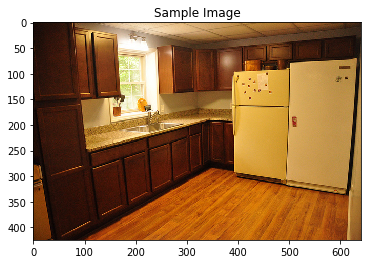

Caption without beam search:
a kitchen with a refrigerator , sink and stove .
Top captions using beam search:
a kitchen with a refrigerator , sink , dishwasher and stove .
a kitchen with a refrigerator a sink and a window
a kitchen with a refrigerator a sink and a window


In [8]:
get_prediction(data_loader, encoder, decoder, vocab)

### The model performed well!

Loop over captions until we encounter two images with relatively accurate captions.

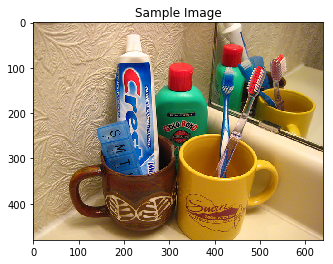

Caption without beam search:
a cup of toothpaste sitting on a table with a bottle of booze .
Top captions using beam search:
a pair of toothbrushes in a cup sitting on a counter .
a cup of toothpaste sitting next to a toothbrush .
a cup of toothpaste sitting next to a toothbrush .


In [9]:
get_prediction(data_loader, encoder, decoder, vocab)

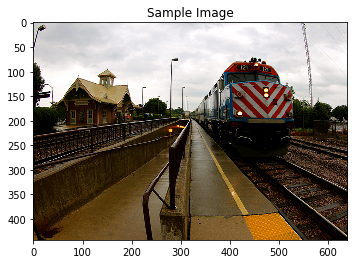

Caption without beam search:
a train traveling down train tracks next to a platform .
Top captions using beam search:
a train traveling down train tracks next to a platform .
a train traveling down train tracks next to a platform .
a train traveling down train tracks next to a platform .


In [10]:
get_prediction(data_loader, encoder, decoder, vocab)

### The model could have performed better ...

Loop over captions until we encounter two images with relatively inaccurate captions.

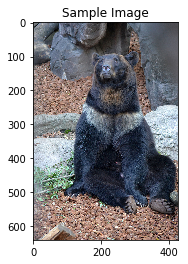

Caption without beam search:
a black bear sitting on a rock in a garden .
Top captions using beam search:
a large black bear sitting on top of a fallen tree .
a black bear sitting on top of a fallen tree .
a black bear sitting on top of a fallen tree .


In [11]:
get_prediction(data_loader, encoder, decoder, vocab)

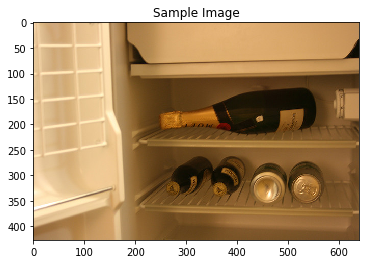

Caption without beam search:
a refrigerator filled with lots of food and drinks .
Top captions using beam search:
a white refrigerator filled with lots of food .
a white refrigerator filled with lots of food .
a white refrigerator filled with lots of food .


In [12]:
get_prediction(data_loader, encoder, decoder, vocab)